In [1]:
# !pip install -q datasets diffusers torchaudio accelerate
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline
from torchaudio import transforms as AT
from torchvision import transforms as IT

In [2]:
# 加载一个预训练的音频扩散模型管线
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "teticio/audio-diffusion-instrumental-hiphop-256"
model_id = r"G:\code\pretrain_model_dir\audio-diffusion-instrumental-hiphop-256"
pipe = DiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

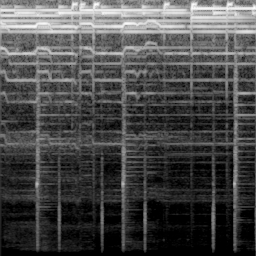

In [3]:
# 在管线中采样一次并将采样结果显示出来
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))

In [4]:
# 音频序列
output.audios[0].shape

(1, 130560)

In [5]:
# 输出的图像（频谱）
output.images[0].size

(256, 256)

In [6]:
pipe

AudioDiffusionPipeline {
  "_class_name": "AudioDiffusionPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "G:\\code\\pretrain_model_dir\\audio-diffusion-instrumental-hiphop-256",
  "mel": [
    "audio_diffusion",
    "Mel"
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ],
  "vqvae": [
    null,
    null
  ]
}

tensor(4.8309e-14) tensor(1.9067)


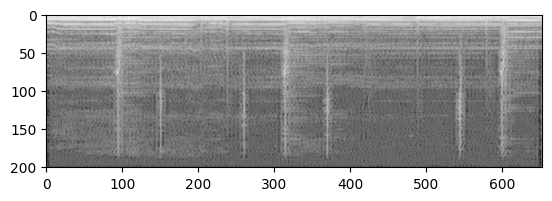

In [7]:
# 使用torchaudio模块计算并绘制所生成音频样本的频谱，如图8-2所示
spec_transform = AT.Spectrogram(power=2)
spectrogram = spec_transform(torch.tensor(output.audios[0]))
print(spectrogram.min(), spectrogram.max())
log_spectrogram = spectrogram.log()
plt.imshow(log_spectrogram[0], cmap='gray')

In [8]:
a = pipe.mel.image_to_audio(output.images[0])
a.shape

(130560,)

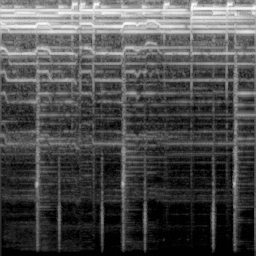

In [9]:
pipe.mel.load_audio(raw_audio=a)
im = pipe.mel.audio_slice_to_image(0)
im

In [10]:
sample_rate_pipeline = pipe.mel.get_sample_rate()
sample_rate_pipeline

22050

In [11]:
display(Audio(output.audios[0], rate=44100)) # 播放速度被加倍

In [12]:
from datasets import load_dataset
dataset = load_dataset('lewtun/music_genres', split='train', cache_dir="./data/music_genres")
dataset

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 19909
})

In [13]:
for g in list(set(dataset['genre'])):
    print(g, sum(x==g for x in dataset['genre']))

Old-Time / Historic 408
Classical 495
Blues 58
Experimental 1800
International 814
Ambient Electronic 796
Rock 3095
Country 142
Hip-Hop 1757
Folk 1214
Chiptune / Glitch 1181
Jazz 306
Electronic 3071
Instrumental 1044
Spoken 94
Punk 2582
Easy Listening 13
Soul-RnB 94
Pop 945


In [14]:
audio_array = dataset[0]['audio']['array']
sample_rate_dataset = dataset[0]['audio']['sampling_rate']
print('Audio array shape:', audio_array.shape)
print('Sample rate:', sample_rate_dataset)

Audio array shape: (1323119,)
Sample rate: 44100


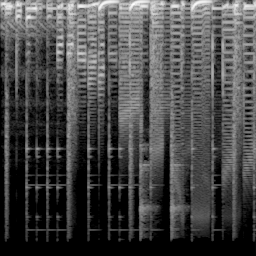

In [15]:
a = dataset[0]['audio']['array']  # 得到音频序列
pipe.mel.load_audio(raw_audio=a)  # 使用pipe.mel加载音频
pipe.mel.audio_slice_to_image(0)  # 输出第一幅频谱图像，如图8-5所示

In [16]:
sample_rate_dataset = dataset[0]['audio']['sampling_rate']
sample_rate_dataset

44100

In [17]:
resampler = AT.Resample(sample_rate_dataset, sample_rate_pipeline,  dtype=torch.float32)
to_t = IT.ToTensor()

def to_image(audio_array):
    audio_tensor = torch.tensor(audio_array).to(torch.float32)
    audio_tensor = resampler(audio_tensor)
    pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
    num_slices = pipe.mel.get_number_of_slices()
    slice_idx = random.randint(0, num_slices-1)  # 每次随机取一张（除了最后那张）
    im = pipe.mel.audio_slice_to_image(slice_idx)
    return im

In [18]:
def collate_fn(examples):
# 图像→张量→缩放至(-1,1)区间→堆叠
  audio_ims = [to_t(to_image(x['audio']['array']))*2-1 for x in examples]
  return torch.stack(audio_ims)

# 创建一个只包含Chiptune/Glitch（芯片音乐/电子脉冲）风格的音乐
batch_size=4                   # 在CoLab中设置为4，在A100上设置为12
chosen_genre = 'Electronic'    # <<< 尝试在不同的风格上进行训练 <<<
indexes = [i for i, g in enumerate(dataset['genre']) if g == chosen_genre]
filtered_dataset = dataset.select(indexes)
dl = torch.utils.data.DataLoader(filtered_dataset.shuffle(), batch_size=batch_size,
collate_fn=collate_fn, shuffle=True)
batch = next(iter(dl))
print(batch.shape)

torch.Size([4, 1, 256, 256])


  0%|          | 0/768 [00:00<?, ?it/s]

g:\code\ai\stable-diffusion-webui_tobe\venv\lib\site-packages\diffusers\configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

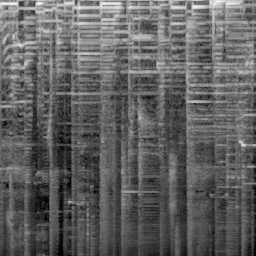

TypeError: 'int' object is not subscriptable

In [19]:
epochs = 3
lr = 1e-4

pipe.unet.train()
pipe.scheduler.set_timesteps(1000)
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dl), total=len(dl)):
        # 准备输入图片

        clean_images = batch.to(device)
        bs = clean_images.shape[0]

        # 为每一张图片设置一个随机的时间步

        timesteps = torch.randint(
            0, pipe.scheduler.num_train_timesteps, (bs,),
            device=clean_images.device
        ).long()
        # 按照噪声调度器，在每个时间步为干净的图片加上噪声

        noise = torch.randn(clean_images.shape).to(clean_images.
            device)
        noisy_images = pipe.scheduler.add_noise(clean_images,
            noise, timesteps)
            # 得到模型的预测结果

        noise_pred = pipe.unet(noisy_images, timesteps, return_dict=False)[0]
        # 计算损失函数
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # 使用优化器更新模型参数
        optimizer.step()
        optimizer.zero_grad()


In [22]:
pipe.unet.sample_size

256

  0%|          | 0/1000 [00:00<?, ?it/s]

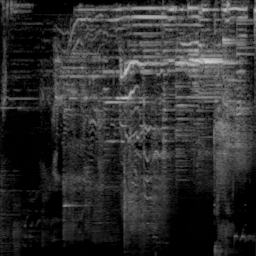

  0%|          | 0/1000 [00:00<?, ?it/s]

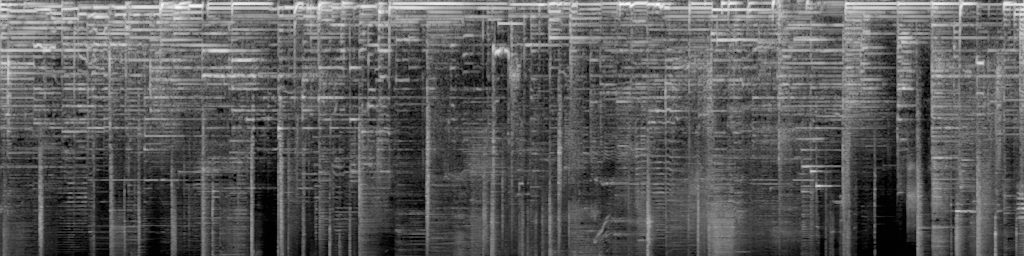

In [23]:
# 装载之前训练好的频谱样本，如图8-6所示
# pipe = DiffusionPipeline.from_pretrained("johnowhitaker/Electronic_test").to(device)
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=22050))
# 输入一个不同形状的起点噪声张量，得到一个更长的频谱样本，如图8-7所示
noise = torch.randn(1, 1, pipe.unet.sample_size,pipe.unet.sample_size*4).to(device)
output = pipe(noise=noise)
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

# 上传模型

In [ ]:
# from huggingface_hub import get_full_repo_name, HfApi, create_repo, ModelCard
# # 给模型取个名字
# model_name = "audio-diffusion-electronic"
# hub_model_id = get_full_repo_name(model_name)
# # 在本地文件夹中保存管线
# pipe.save_pretrained(model_name)
# # 插入本地文件夹中的内容
# !ls {model_name}
# # 构建仓库
# create_repo(hub_model_id)
# # 上传文件
# api = HfApi()
# api.upload_folder(
#    folder_path=f"{model_name}/scheduler", path_in_repo="scheduler", repo_id=hub_model_id
# )
# api.upload_folder(
#    folder_path=f"{model_name}/mel", path_in_repo="mel", repo_id=hub_model_id
# )
# api.upload_folder(folder_path=f"{model_name}/unet", path_in_repo="unet", repo_id=hub_model_id)
# api.upload_file(
#     path_or_fileobj=f"{model_name}/model_index.json",
#     path_in_repo="model_index.json",
#     repo_id=hub_model_id,
# )
# # 模型卡片
# content = f"""
# ---
# license: mit
# tags:
# - pytorch
# - diffusers
# - unconditional-audio-generation
# - diffusion-models-class
# ---

# # [扩散模型课程]第8章 模型卡片
# 这个模型是一个旨在生成{chosen_genre}风格音乐的非条件性扩散模型
# # 用法

# '''python
# from IPython.display import Audio
# from diffusers import DiffusionPipeline

# pipe = DiffusionPipeline.from_pretrained("{hub_model_id}")
# output = pipe()
# display(output.images[0])
# display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))"""
# card = ModelCard(content)
# card.push_to_hub(hub_model_id)